In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sun Feb 11 07:56:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 34%   62C    P8              17W / 215W |    370MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [24]:
%reset -f

In [23]:
del model
gc.collect()

25

In [3]:
import gc
import os
os.chdir('IConNet')

In [4]:
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
from torchaudio.datasets import IEMOCAP
data_dir = '../data/IEMOCAP/'
val_set = IEMOCAP(root=data_dir, sessions=(1,), utterance_type='scripted')

In [8]:
val_set.get_metadata(n=10)

('Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav',
 16000,
 'Ses01F_script01_1_F023',
 'fru',
 'Ses01F')

Shape of waveform: torch.Size([1, 49759])
Sample rate: 16000 Hz, emotion label: fru


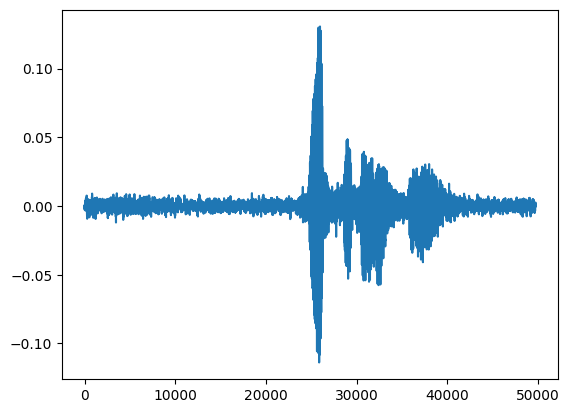

In [9]:
waveform, sample_rate, filename, label, speaker_id = val_set.__getitem__(0)
print("Shape of waveform: {}".format(waveform.size()))
print(f"Sample rate: {sample_rate} Hz, emotion label: {label}")
plt.plot(waveform.t().numpy())

In [10]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = IEMOCAP(root=data_dir, sessions=(1,2,3,5), utterance_type='scripted')
test_set = IEMOCAP(root=data_dir, sessions=(4,), utterance_type='scripted')

In [11]:
labels = sorted(list(set(datapoint[3] for datapoint in train_set)))
labels

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']

In [12]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate, dtype=torch.float32)
transformed = transform(waveform)
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "hap"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

hap --> tensor(3) --> hap


In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 8

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [15]:
from IConNet.nn.model import M12

In [16]:
from omegaconf import OmegaConf as ocf

In [17]:
model_config_path = 'config/model/m12.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M12', 'description': 'gated residual FirConv', 'fe': {'n_block': 2, 'n_channel': [48, 48], 'kernel_size': [511, 127], 'stride': [4, 4], 'window_k': [2, 9], 'residual_connection_type': 'concat', 'pooling': False}, 'seq': {'n_block': 1, 'n_channel': 32, 'pooling': 'mean', 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [128, 128]}}

In [18]:
model = M12(config=model_config,
            n_input=1, n_output=len(labels))
model

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(48, 32, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=96, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [19]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = transform(data)
        data_length = len(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        del data
        gc.collect()
        torch.cuda.empty_cache()
        loss = F.cross_entropy(output.squeeze(), target)
        del target
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [22]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                          | 0.004618937644341801/10 [00:00<25:11, 151.22s/it]

Train Epoch: 1 [0/2793 (0%)]	Loss: 1.830618


  2%|█▊                                                                          | 0.23556581986143155/10 [00:21<14:30, 89.13s/it]

Train Epoch: 1 [800/2793 (4%)]	Loss: 1.539318


  5%|███▌                                                                        | 0.46651270207852374/10 [00:42<13:53, 87.42s/it]

Train Epoch: 1 [1600/2793 (7%)]	Loss: 1.699448


  7%|█████▎                                                                      | 0.6974595842956114/10 [01:03<16:02, 103.47s/it]

Train Epoch: 1 [2400/2793 (11%)]	Loss: 1.746494


 10%|███████▊                                                                      | 1.002309468822166/10 [01:27<10:52, 72.55s/it]


Test Epoch: 1	Accuracy: 258/673 (38%)

Train Epoch: 2 [0/2793 (0%)]	Loss: 1.628696


 12%|█████████▋                                                                    | 1.235565819861435/10 [01:49<13:29, 92.42s/it]

Train Epoch: 2 [800/2793 (4%)]	Loss: 1.574945


 15%|███████████▍                                                                  | 1.464203233256362/10 [02:09<13:25, 94.32s/it]

Train Epoch: 2 [1600/2793 (7%)]	Loss: 1.504114


 17%|█████████████                                                                | 1.6974595842956308/10 [02:30<13:09, 95.08s/it]

Train Epoch: 2 [2400/2793 (11%)]	Loss: 1.475571


 20%|███████████████▌                                                              | 2.000000000000029/10 [02:54<09:10, 68.78s/it]


Test Epoch: 2	Accuracy: 303/673 (45%)



 20%|███████████████▍                                                             | 2.0046189376443704/10 [02:54<10:06, 75.88s/it]

Train Epoch: 3 [0/2793 (0%)]	Loss: 1.706803


 22%|█████████████████▍                                                            | 2.235565819861446/10 [03:15<11:54, 91.99s/it]

Train Epoch: 3 [800/2793 (4%)]	Loss: 1.644376


 25%|███████████████████▏                                                          | 2.464203233256351/10 [03:36<12:23, 98.69s/it]

Train Epoch: 3 [1600/2793 (7%)]	Loss: 1.141978


 27%|████████████████████▊                                                        | 2.6951501154734268/10 [03:57<10:52, 89.31s/it]

Train Epoch: 3 [2400/2793 (11%)]	Loss: 1.656430


 30%|███████████████████████                                                      | 2.9999999999999667/10 [04:21<08:00, 68.71s/it]


Test Epoch: 3	Accuracy: 294/673 (44%)



 30%|███████████████████████▍                                                      | 3.004618937644308/10 [04:21<09:17, 79.75s/it]

Train Epoch: 4 [0/2793 (0%)]	Loss: 1.404897


 32%|████████████████████████▉                                                    | 3.233256351039213/10 [04:42<11:35, 102.76s/it]

Train Epoch: 4 [800/2793 (4%)]	Loss: 1.704845


 35%|██████████████████████████▋                                                  | 3.4665127020784596/10 [05:04<09:30, 87.25s/it]

Train Epoch: 4 [1600/2793 (7%)]	Loss: 1.838640


 37%|████████████████████████████▍                                                | 3.6974595842955353/10 [05:25<09:23, 89.33s/it]

Train Epoch: 4 [2400/2793 (11%)]	Loss: 1.179239


 40%|██████████████████████████████▊                                              | 3.9999999999999045/10 [05:49<06:53, 68.85s/it]


Test Epoch: 4	Accuracy: 200/673 (30%)



 40%|██████████████████████████████▊                                              | 4.0046189376442465/10 [05:50<07:41, 77.00s/it]

Train Epoch: 5 [0/2793 (0%)]	Loss: 1.508968


 42%|█████████████████████████████████                                             | 4.233256351039151/10 [06:10<09:01, 93.83s/it]

Train Epoch: 5 [800/2793 (4%)]	Loss: 1.573509


 45%|██████████████████████████████████▊                                           | 4.464203233256227/10 [06:31<08:17, 89.78s/it]

Train Epoch: 5 [1600/2793 (7%)]	Loss: 1.545018


 47%|████████████████████████████████████▌                                         | 4.695150115473303/10 [06:52<08:08, 92.12s/it]

Train Epoch: 5 [2400/2793 (11%)]	Loss: 1.556402


 50%|██████████████████████████████████████▉                                       | 4.999999999999843/10 [07:16<05:39, 67.89s/it]


Test Epoch: 5	Accuracy: 280/673 (42%)



 50%|███████████████████████████████████████                                       | 5.004618937644184/10 [07:16<06:45, 81.20s/it]

Train Epoch: 6 [0/2793 (0%)]	Loss: 1.606279


 52%|████████████████████████████████████████▊                                     | 5.23556581986126/10 [07:37<07:59, 100.60s/it]

Train Epoch: 6 [800/2793 (4%)]	Loss: 2.412661


 55%|██████████████████████████████████████████▋                                   | 5.466512702078336/10 [07:58<06:28, 85.77s/it]

Train Epoch: 6 [1600/2793 (7%)]	Loss: 1.897299


 57%|████████████████████████████████████████████▍                                 | 5.695150115473241/10 [08:19<06:26, 89.88s/it]

Train Epoch: 6 [2400/2793 (11%)]	Loss: 1.478840


 60%|██████████████████████████████████████████████▊                               | 6.002309468821951/10 [08:43<04:56, 74.11s/it]


Test Epoch: 6	Accuracy: 312/673 (46%)

Train Epoch: 7 [0/2793 (0%)]	Loss: 2.094033


 62%|████████████████████████████████████████████████▌                             | 6.233256351039027/10 [09:05<05:39, 90.20s/it]

Train Epoch: 7 [800/2793 (4%)]	Loss: 1.535285


 65%|██████████████████████████████████████████████████▍                           | 6.464203233256103/10 [09:26<05:23, 91.56s/it]

Train Epoch: 7 [1600/2793 (7%)]	Loss: 1.589589


 67%|████████████████████████████████████████████████████▏                         | 6.697459584295349/10 [09:48<04:45, 86.54s/it]

Train Epoch: 7 [2400/2793 (11%)]	Loss: 1.865002


 70%|█████████████████████████████████████████████████████▉                       | 6.9999999999997184/10 [10:12<03:33, 71.28s/it]


Test Epoch: 7	Accuracy: 300/673 (45%)



 70%|███████████████████████████████████████████████████████▎                       | 7.00461893764406/10 [10:13<04:02, 81.12s/it]

Train Epoch: 8 [0/2793 (0%)]	Loss: 1.408251


 72%|████████████████████████████████████████████████████████▍                     | 7.235565819861136/10 [10:33<03:50, 83.46s/it]

Train Epoch: 8 [800/2793 (4%)]	Loss: 2.155061


 75%|██████████████████████████████████████████████████████████▏                   | 7.466512702078211/10 [10:54<04:07, 97.77s/it]

Train Epoch: 8 [1600/2793 (7%)]	Loss: 1.716019


 77%|████████████████████████████████████████████████████████████                  | 7.697459584295287/10 [11:15<03:30, 91.53s/it]

Train Epoch: 8 [2400/2793 (11%)]	Loss: 1.685972


 80%|██████████████████████████████████████████████████████████████▍               | 7.999999999999656/10 [11:39<02:17, 68.51s/it]


Test Epoch: 8	Accuracy: 275/673 (41%)



 80%|██████████████████████████████████████████████████████████████▍               | 8.002309468821828/10 [11:39<02:37, 78.61s/it]

Train Epoch: 9 [0/2793 (0%)]	Loss: 1.457110


 82%|████████████████████████████████████████████████████████████████▏             | 8.235565819861074/10 [12:00<02:28, 84.41s/it]

Train Epoch: 9 [800/2793 (4%)]	Loss: 1.397011


 85%|██████████████████████████████████████████████████████████████████▊            | 8.46420323325598/10 [12:22<02:19, 91.00s/it]

Train Epoch: 9 [1600/2793 (7%)]	Loss: 1.107536


 87%|███████████████████████████████████████████████████████████████████▊          | 8.695150115473055/10 [12:42<02:00, 92.37s/it]

Train Epoch: 9 [2400/2793 (11%)]	Loss: 1.419477


 90%|██████████████████████████████████████████████████████████████████████▏       | 8.999999999999595/10 [13:07<01:09, 69.27s/it]


Test Epoch: 9	Accuracy: 232/673 (34%)



 90%|██████████████████████████████████████████████████████████████████████▏       | 9.002309468821766/10 [13:07<01:34, 94.63s/it]

Train Epoch: 10 [0/2793 (0%)]	Loss: 1.151583


 92%|███████████████████████████████████████████████████████████████████████      | 9.233256351038841/10 [13:28<01:20, 105.32s/it]

Train Epoch: 10 [800/2793 (4%)]	Loss: 1.595562


 95%|█████████████████████████████████████████████████████████████████████████▊    | 9.464203233255917/10 [13:49<00:47, 89.12s/it]

Train Epoch: 10 [1600/2793 (7%)]	Loss: 1.522315


 97%|███████████████████████████████████████████████████████████████████████████▋  | 9.697459584295164/10 [14:10<00:26, 88.82s/it]

Train Epoch: 10 [2400/2793 (11%)]	Loss: 1.303435


100%|█████████████████████████████████████████████████████████████████████████████▉| 9.999999999999533/10 [14:34<00:00, 87.49s/it]


Test Epoch: 10	Accuracy: 228/673 (34%)



In [23]:
layer = model.fe_blocks.blocks[0].layer
from IConNet.visualizer import visualize_model
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0102],
        [0.0228],
        [0.0384],
        [0.0576],
        [0.0813],
        [0.1105],
        [0.1465],
        [0.1910],
        [0.2458],
        [0.3135],
        [0.3970],
        [0.0000],
        [0.0150],
        [0.0327],
        [0.0534],
        [0.0776],
        [0.1060],
        [0.1392],
        [0.1782],
        [0.2239],
        [0.2775],
        [0.3402],
        [0.4138],
        [0.0000],
        [0.0208],
        [0.0442],
        [0.0702],
        [0.0994],
        [0.1321],
        [0.1687],
        [0.2096],
        [0.2554],
        [0.3067],
        [0.3640],
        [0.4282],
        [0.0000],
        [0.0269],
        [0.0558],
        [0.0869],
        [0.1205],
        [0.1566],
        [0.1954],
        [0.2373],
        [0.2824],
        [0.3309],
        [0.3832],
        [0.4394]], device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0102],
   

In [24]:
visualize_model.count_parameters(model)

66182

In [25]:
visualize_model.count_parameters(model.fe_blocks)

25536

In [26]:
[print(p.grad) for p in model.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 1.4660e-16],
        [-1.2357e-16],
        [-2.9086e-17],
        [-4.8237e-17],
        [-1.5664e-16],
        [-5.2867e-14],
        [ 4.5234e-14],
        [-6.0121e-17],
        [-1.3960e-17],
        [-2.7580e-17],
        [ 1.8182e-17],
        [ 0.0000e+00],
        [-5.8405e-16],
        [-5.1026e-17],
        [-3.8856e-17],
        [ 4.9814e-17],
        [ 1.2627e-15],
        [ 1.0685e-16],
        [ 4.4521e-17],
        [-1.5039e-18],
        [-8.2125e-17],
        [ 3.2179e-17],
        [-5.8415e-17],
        [ 0.0000e+00],
        [ 1.0368e-16],
        [ 1.5938e-15],
        [ 3.9980e-15],
        [ 1.0878e-16],
        [-5.3067e-17],
        [ 4.5835e-16],
        [-3.1741e-17],
        [-2.4775e-15],
        [ 8.6826e-15],
        [ 3.5824e-18],
        [ 2.5075e-17],
        [ 0.0000e+00],
        [ 1.3169e-17],
        [-2.1717e-17],
        [ 1.7923e-17],
        [-1.2858e-16],
        [-2.8707e-16],
        [-3.9341e-16],
        [-1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

In [28]:
model.eval()

= 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 120/673 (0.1783)
F1: 0.1785714328289032
UAP: 0.22178463637828827
WAP: 0.1785714328289032
UAR: 0.21463429927825928
WAR: 0.1785714328289032


NameError: name 'cm' is not defined

In [29]:
cm = confusion_matrix.compute()
print(cm)

tensor([[  8,   0, 148,   0,   6,  80],
        [  1,   0,  30,   0,   2,  41],
        [  0,   0,  52,   0,  11, 113],
        [  0,   0,   6,   0,   1,  27],
        [  0,   0,   9,   0,   2,  73],
        [  0,   0,   2,   0,   2,  58]], device='cuda:0')


In [30]:
labels

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']

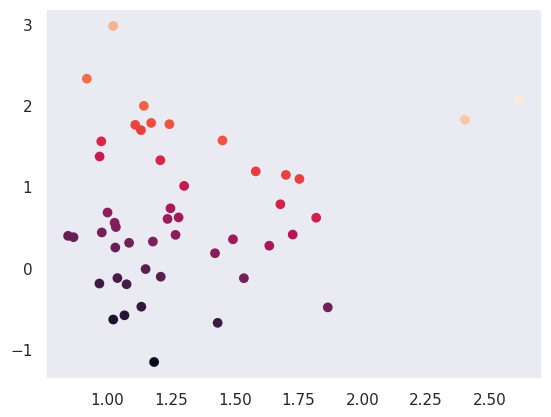

In [33]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = 8000
)
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


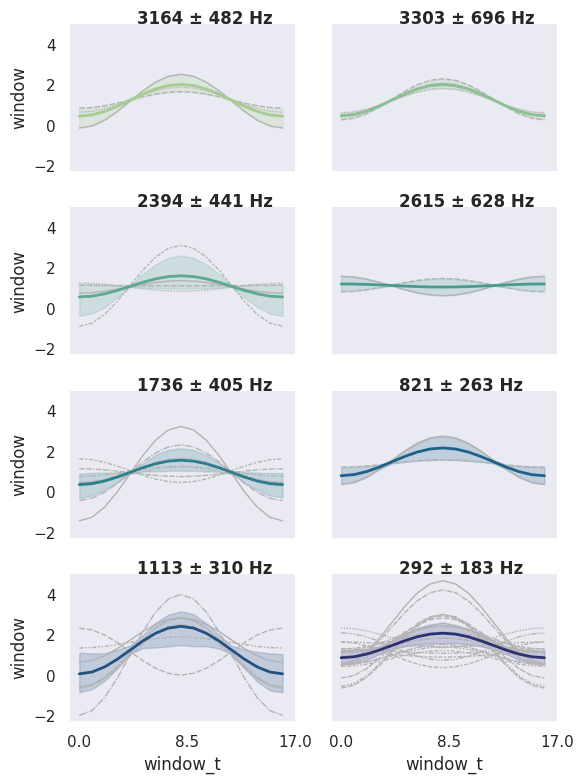

In [34]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


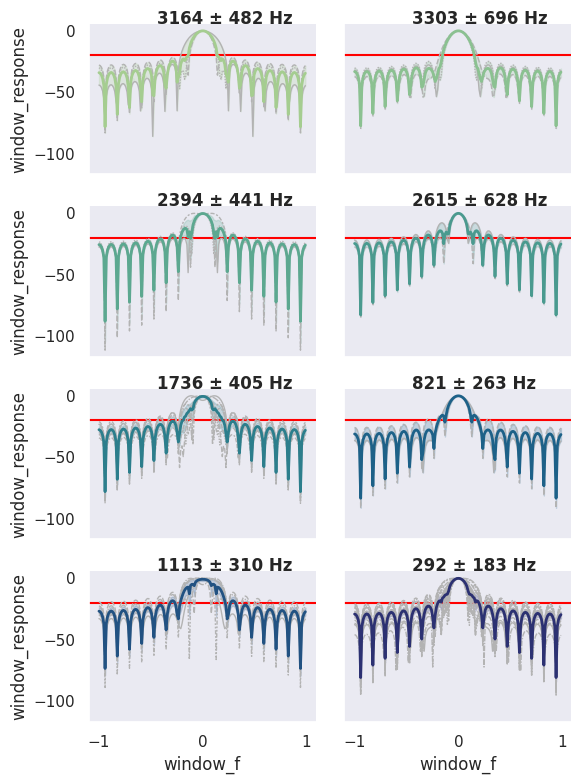

In [35]:
filtviz.visualize_filters(filter_domain='freq')

In [37]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

In [38]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch, n_epoch + 1 + n_epoch2):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                       | 0.0023094688221709007/50 [00:00<2:08:27, 154.17s/it]

Train Epoch: 11 [0/2793 (0%)]	Loss: 1.379378


  0%|▎                                                                        | 0.23325635103926065/50 [00:25<1:36:32, 116.38s/it]

Train Epoch: 11 [800/2793 (4%)]	Loss: 1.309270


  1%|▋                                                                         | 0.4642032332563528/50 [00:50<1:37:56, 118.63s/it]

Train Epoch: 11 [1600/2793 (7%)]	Loss: 1.372361


  1%|█                                                                         | 0.6951501154734405/50 [01:16<1:28:58, 108.27s/it]

Train Epoch: 11 [2400/2793 (11%)]	Loss: 1.464127


  2%|█▍                                                                         | 0.9999999999999951/50 [01:45<1:11:52, 88.00s/it]


Test Epoch: 11	Accuracy: 290/673 (43%)



  2%|█▌                                                                          | 1.002309468822166/50 [01:46<1:20:23, 98.45s/it]

Train Epoch: 12 [0/2793 (0%)]	Loss: 1.078465


  2%|█▊                                                                         | 1.233256351039264/50 [02:11<1:31:53, 113.06s/it]

Train Epoch: 12 [800/2793 (4%)]	Loss: 1.525981


  3%|██▏                                                                        | 1.464203233256362/50 [02:36<1:38:24, 121.66s/it]

Train Epoch: 12 [1600/2793 (7%)]	Loss: 1.520485


  3%|██▌                                                                       | 1.6951501154734598/50 [03:01<1:27:35, 108.79s/it]

Train Epoch: 12 [2400/2793 (11%)]	Loss: 1.298771


  4%|███                                                                         | 2.000000000000029/50 [03:30<1:06:26, 83.06s/it]


Test Epoch: 12	Accuracy: 296/673 (44%)



  4%|███                                                                        | 2.0023094688221996/50 [03:30<1:14:41, 93.36s/it]

Train Epoch: 13 [0/2793 (0%)]	Loss: 1.728082


  4%|███▎                                                                      | 2.2332563510392753/50 [03:55<1:25:44, 107.70s/it]

Train Epoch: 13 [800/2793 (4%)]	Loss: 1.394310


  5%|███▋                                                                       | 2.464203233256351/50 [04:20<1:20:01, 101.01s/it]

Train Epoch: 13 [1600/2793 (7%)]	Loss: 1.729655


  5%|███▉                                                                      | 2.6951501154734268/50 [04:45<1:26:10, 109.31s/it]

Train Epoch: 13 [2400/2793 (11%)]	Loss: 1.335329


  6%|████▍                                                                      | 2.9999999999999667/50 [05:14<1:04:10, 81.92s/it]


Test Epoch: 13	Accuracy: 291/673 (43%)



  6%|████▌                                                                      | 3.0023094688221375/50 [05:15<1:10:02, 89.41s/it]

Train Epoch: 14 [0/2793 (0%)]	Loss: 1.459197


  6%|████▊                                                                      | 3.233256351039213/50 [05:40<1:22:50, 106.29s/it]

Train Epoch: 14 [800/2793 (4%)]	Loss: 1.541552


  7%|█████▏                                                                     | 3.464203233256289/50 [06:05<1:28:11, 113.71s/it]

Train Epoch: 14 [1600/2793 (7%)]	Loss: 1.121613


  7%|█████▍                                                                    | 3.6951501154733646/50 [06:30<1:20:33, 104.39s/it]

Train Epoch: 14 [2400/2793 (11%)]	Loss: 1.412166


  8%|█████▉                                                                     | 3.9999999999999045/50 [06:59<1:05:52, 85.92s/it]


Test Epoch: 14	Accuracy: 298/673 (44%)



  8%|██████                                                                      | 4.002309468822076/50 [06:59<1:15:02, 97.88s/it]

Train Epoch: 15 [0/2793 (0%)]	Loss: 1.168121


  8%|██████▎                                                                    | 4.233256351039151/50 [07:25<1:37:36, 127.97s/it]

Train Epoch: 15 [800/2793 (4%)]	Loss: 1.590904


  9%|██████▋                                                                    | 4.464203233256227/50 [07:50<1:23:30, 110.03s/it]

Train Epoch: 15 [1600/2793 (7%)]	Loss: 1.748192


  9%|███████                                                                    | 4.695150115473303/50 [08:15<1:30:17, 119.57s/it]

Train Epoch: 15 [2400/2793 (11%)]	Loss: 1.263921


 10%|███████▌                                                                    | 4.999999999999843/50 [08:45<1:04:13, 85.62s/it]


Test Epoch: 15	Accuracy: 289/673 (43%)



 10%|███████▌                                                                   | 5.0023094688220135/50 [08:45<1:10:58, 94.63s/it]

Train Epoch: 16 [0/2793 (0%)]	Loss: 1.146522


 10%|███████▊                                                                   | 5.233256351039089/50 [09:10<1:25:28, 114.55s/it]

Train Epoch: 16 [800/2793 (4%)]	Loss: 1.459780


 11%|████████▏                                                                  | 5.464203233256165/50 [09:35<1:18:44, 106.07s/it]

Train Epoch: 16 [1600/2793 (7%)]	Loss: 1.869165


 11%|████████▌                                                                  | 5.695150115473241/50 [10:01<1:18:58, 106.96s/it]

Train Epoch: 16 [2400/2793 (11%)]	Loss: 1.474395


 12%|█████████                                                                   | 5.999999999999781/50 [10:30<1:01:25, 83.75s/it]


Test Epoch: 16	Accuracy: 294/673 (44%)



 12%|█████████                                                                   | 6.002309468821951/50 [10:31<1:09:24, 94.66s/it]

Train Epoch: 17 [0/2793 (0%)]	Loss: 1.104289


 12%|█████████▎                                                                 | 6.233256351039027/50 [10:56<1:24:09, 115.36s/it]

Train Epoch: 17 [800/2793 (4%)]	Loss: 1.269093


 13%|█████████▋                                                                 | 6.464203233256103/50 [11:22<1:17:42, 107.10s/it]

Train Epoch: 17 [1600/2793 (7%)]	Loss: 1.047366


 13%|█████████▉                                                                | 6.6951501154731785/50 [11:48<1:21:27, 112.87s/it]

Train Epoch: 17 [2400/2793 (11%)]	Loss: 1.093591


 14%|██████████▍                                                                | 6.9999999999997184/50 [12:17<1:00:36, 84.57s/it]


Test Epoch: 17	Accuracy: 288/673 (43%)



 14%|██████████▋                                                                 | 7.002309468821889/50 [12:17<1:11:11, 99.35s/it]

Train Epoch: 18 [0/2793 (0%)]	Loss: 1.369350


 14%|██████████▊                                                                | 7.233256351038965/50 [12:42<1:19:14, 111.17s/it]

Train Epoch: 18 [800/2793 (4%)]	Loss: 1.695333


 15%|███████████▏                                                               | 7.464203233256041/50 [13:08<1:17:39, 109.55s/it]

Train Epoch: 18 [1600/2793 (7%)]	Loss: 1.636809


 15%|███████████▌                                                               | 7.695150115473116/50 [13:33<1:39:32, 141.17s/it]

Train Epoch: 18 [2400/2793 (11%)]	Loss: 1.102871


 16%|████████████▍                                                                 | 7.999999999999656/50 [14:03<59:18, 84.72s/it]


Test Epoch: 18	Accuracy: 297/673 (44%)



 16%|████████████▏                                                               | 8.002309468821828/50 [14:03<1:02:59, 89.99s/it]

Train Epoch: 19 [0/2793 (0%)]	Loss: 1.175736


 16%|████████████▎                                                              | 8.233256351038904/50 [14:29<1:23:09, 119.47s/it]

Train Epoch: 19 [800/2793 (4%)]	Loss: 1.516944


 17%|████████████▊                                                               | 8.46420323325598/50 [14:55<1:16:37, 110.69s/it]

Train Epoch: 19 [1600/2793 (7%)]	Loss: 1.911660


 17%|█████████████                                                              | 8.695150115473055/50 [15:21<1:11:49, 104.34s/it]

Train Epoch: 19 [2400/2793 (11%)]	Loss: 1.476351


 18%|██████████████                                                                | 8.999999999999595/50 [15:49<57:55, 84.76s/it]


Test Epoch: 19	Accuracy: 280/673 (42%)



 18%|█████████████▌                                                             | 9.002309468821766/50 [15:50<1:22:11, 120.30s/it]

Train Epoch: 20 [0/2793 (0%)]	Loss: 1.303212


 18%|█████████████▊                                                             | 9.233256351038841/50 [16:15<1:21:17, 119.65s/it]

Train Epoch: 20 [800/2793 (4%)]	Loss: 1.743531


 19%|██████████████▏                                                            | 9.464203233255917/50 [16:40<1:11:00, 105.11s/it]

Train Epoch: 20 [1600/2793 (7%)]	Loss: 1.491951


 19%|██████████████▌                                                            | 9.695150115472993/50 [17:06<1:15:21, 112.19s/it]

Train Epoch: 20 [2400/2793 (11%)]	Loss: 1.425620


 20%|███████████████▌                                                              | 9.999999999999533/50 [17:35<57:33, 86.34s/it]


Test Epoch: 20	Accuracy: 292/673 (43%)



 20%|███████████████                                                            | 10.002309468821704/50 [17:35<1:00:08, 90.22s/it]

Train Epoch: 21 [0/2793 (0%)]	Loss: 1.270198


 20%|███████████████▎                                                           | 10.23325635103878/50 [18:00<1:16:17, 115.10s/it]

Train Epoch: 21 [800/2793 (4%)]	Loss: 1.309347


 21%|███████████████▍                                                          | 10.464203233255855/50 [18:26<1:19:03, 119.98s/it]

Train Epoch: 21 [1600/2793 (7%)]	Loss: 0.935026


 21%|████████████████                                                           | 10.69515011547293/50 [18:51<1:10:04, 106.97s/it]

Train Epoch: 21 [2400/2793 (11%)]	Loss: 1.376250


 22%|█████████████████▏                                                            | 10.99999999999947/50 [19:21<55:15, 85.01s/it]


Test Epoch: 21	Accuracy: 270/673 (40%)



 22%|████████████████▉                                                            | 11.002309468821641/50 [19:21<57:18, 88.16s/it]

Train Epoch: 22 [0/2793 (0%)]	Loss: 1.607960


 22%|████████████████▋                                                         | 11.233256351038717/50 [19:47<1:20:33, 124.68s/it]

Train Epoch: 22 [800/2793 (4%)]	Loss: 1.486859


 23%|████████████████▉                                                         | 11.464203233255793/50 [20:12<1:07:07, 104.52s/it]

Train Epoch: 22 [1600/2793 (7%)]	Loss: 1.757337


 23%|█████████████████▎                                                        | 11.695150115472869/50 [20:37<1:12:59, 114.33s/it]

Train Epoch: 22 [2400/2793 (11%)]	Loss: 1.276265


 24%|██████████████████▍                                                          | 11.999999999999408/50 [21:07<52:51, 83.46s/it]


Test Epoch: 22	Accuracy: 287/673 (43%)



 24%|██████████████████                                                         | 12.00230946882158/50 [21:07<1:03:41, 100.58s/it]

Train Epoch: 23 [0/2793 (0%)]	Loss: 1.251522


 24%|██████████████████                                                        | 12.233256351038655/50 [21:32<1:12:10, 114.66s/it]

Train Epoch: 23 [800/2793 (4%)]	Loss: 1.403396


 25%|██████████████████▋                                                        | 12.46420323325573/50 [21:58<1:11:27, 114.24s/it]

Train Epoch: 23 [1600/2793 (7%)]	Loss: 1.463149


 25%|██████████████████▊                                                       | 12.695150115472806/50 [22:24<1:08:49, 110.69s/it]

Train Epoch: 23 [2400/2793 (11%)]	Loss: 1.769419


 26%|████████████████████                                                         | 12.999999999999346/50 [22:53<50:59, 82.68s/it]


Test Epoch: 23	Accuracy: 265/673 (39%)



 26%|████████████████████                                                         | 13.002309468821517/50 [22:53<58:08, 94.28s/it]

Train Epoch: 24 [0/2793 (0%)]	Loss: 1.142568


 26%|███████████████████▌                                                      | 13.233256351038593/50 [23:18<1:12:37, 118.52s/it]

Train Epoch: 24 [800/2793 (4%)]	Loss: 1.421523


 27%|███████████████████▉                                                      | 13.464203233255668/50 [23:44<1:05:45, 107.98s/it]

Train Epoch: 24 [1600/2793 (7%)]	Loss: 1.762624


 27%|████████████████████▎                                                     | 13.695150115472744/50 [24:09<1:02:00, 102.48s/it]

Train Epoch: 24 [2400/2793 (11%)]	Loss: 2.019593


 28%|█████████████████████▌                                                       | 13.999999999999284/50 [24:37<51:00, 85.02s/it]


Test Epoch: 24	Accuracy: 283/673 (42%)



 28%|█████████████████████▌                                                       | 14.002309468821455/50 [24:38<56:20, 93.91s/it]

Train Epoch: 25 [0/2793 (0%)]	Loss: 1.594094


 28%|█████████████████████▎                                                     | 14.23325635103853/50 [25:04<1:08:15, 114.52s/it]

Train Epoch: 25 [800/2793 (4%)]	Loss: 1.370657


 29%|█████████████████████▍                                                    | 14.464203233255606/50 [25:29<1:05:42, 110.95s/it]

Train Epoch: 25 [1600/2793 (7%)]	Loss: 1.276148


 29%|█████████████████████▋                                                    | 14.695150115472682/50 [25:54<1:05:25, 111.20s/it]

Train Epoch: 25 [2400/2793 (11%)]	Loss: 1.340193


 30%|███████████████████████                                                      | 14.999999999999222/50 [26:23<49:11, 84.33s/it]


Test Epoch: 25	Accuracy: 284/673 (42%)



 30%|███████████████████████                                                      | 15.002309468821393/50 [26:23<55:55, 95.87s/it]

Train Epoch: 26 [0/2793 (0%)]	Loss: 1.675711


 30%|██████████████████████▌                                                   | 15.233256351038468/50 [26:49<1:04:23, 111.13s/it]

Train Epoch: 26 [800/2793 (4%)]	Loss: 1.385683


 31%|██████████████████████▉                                                   | 15.464203233255544/50 [27:15<1:06:59, 116.38s/it]

Train Epoch: 26 [1600/2793 (7%)]	Loss: 1.205048


 31%|███████████████████████▌                                                   | 15.69515011547262/50 [27:41<1:05:11, 114.03s/it]

Train Epoch: 26 [2400/2793 (11%)]	Loss: 1.063642


 32%|████████████████████████▉                                                     | 15.99999999999916/50 [28:10<48:54, 86.32s/it]


Test Epoch: 26	Accuracy: 290/673 (43%)



 32%|████████████████████████▉                                                     | 16.00230946882133/50 [28:10<55:39, 98.22s/it]

Train Epoch: 27 [0/2793 (0%)]	Loss: 1.554490


 32%|████████████████████████                                                  | 16.233256351038584/50 [28:36<1:03:39, 113.12s/it]

Train Epoch: 27 [800/2793 (4%)]	Loss: 0.914465


 33%|████████████████████████▎                                                 | 16.464203233255837/50 [29:01<1:15:46, 135.58s/it]

Train Epoch: 27 [1600/2793 (7%)]	Loss: 1.504663


 33%|█████████████████████████▋                                                   | 16.69515011547309/50 [29:26<58:54, 106.12s/it]

Train Epoch: 27 [2400/2793 (11%)]	Loss: 1.629604


 34%|██████████████████████████▏                                                  | 16.999999999999865/50 [29:56<48:49, 88.77s/it]


Test Epoch: 27	Accuracy: 281/673 (42%)



 34%|██████████████████████████▏                                                  | 17.002309468822038/50 [29:56<52:29, 95.43s/it]

Train Epoch: 28 [0/2793 (0%)]	Loss: 1.295667


 34%|█████████████████████████▊                                                 | 17.23325635103929/50 [30:22<1:08:40, 125.76s/it]

Train Epoch: 28 [800/2793 (4%)]	Loss: 1.545514


 35%|█████████████████████████▊                                                | 17.464203233256544/50 [30:47<1:02:13, 114.75s/it]

Train Epoch: 28 [1600/2793 (7%)]	Loss: 1.740606


 35%|██████████████████████████▏                                               | 17.695150115473798/50 [31:13<1:01:54, 114.97s/it]

Train Epoch: 28 [2400/2793 (11%)]	Loss: 1.184090


 36%|███████████████████████████▋                                                 | 18.000000000000572/50 [31:42<45:00, 84.41s/it]


Test Epoch: 28	Accuracy: 286/673 (42%)



 36%|███████████████████████████▋                                                 | 18.002309468822745/50 [31:42<49:06, 92.08s/it]

Train Epoch: 29 [0/2793 (0%)]	Loss: 1.804228


 36%|███████████████████████████▋                                                | 18.233256351039998/50 [32:07<54:54, 103.72s/it]

Train Epoch: 29 [800/2793 (4%)]	Loss: 1.588089


 37%|████████████████████████████▍                                                | 18.46420323325725/50 [32:33<59:47, 113.77s/it]

Train Epoch: 29 [1600/2793 (7%)]	Loss: 1.385316


 37%|████████████████████████████▍                                               | 18.695150115474505/50 [32:58<55:28, 106.32s/it]

Train Epoch: 29 [2400/2793 (11%)]	Loss: 1.484319


 38%|█████████████████████████████▎                                               | 19.00000000000128/50 [33:27<53:59, 104.50s/it]


Test Epoch: 29	Accuracy: 290/673 (43%)



 38%|█████████████████████████████▎                                               | 19.00230946882345/50 [33:27<52:30, 101.63s/it]

Train Epoch: 30 [0/2793 (0%)]	Loss: 1.148214


 38%|████████████████████████████▍                                             | 19.233256351040705/50 [33:53<1:07:28, 131.60s/it]

Train Epoch: 30 [800/2793 (4%)]	Loss: 1.750462


 39%|█████████████████████████████▉                                               | 19.464203233257958/50 [34:18<50:50, 99.90s/it]

Train Epoch: 30 [1600/2793 (7%)]	Loss: 1.559083


 39%|██████████████████████████████▎                                              | 19.69515011547521/50 [34:43<57:17, 113.44s/it]

Train Epoch: 30 [2400/2793 (11%)]	Loss: 0.791293


 40%|██████████████████████████████▊                                              | 20.000000000001986/50 [35:12<41:11, 82.38s/it]


Test Epoch: 30	Accuracy: 279/673 (41%)



 40%|███████████████████████████████▏                                              | 20.00230946882416/50 [35:13<47:03, 94.11s/it]

Train Epoch: 31 [0/2793 (0%)]	Loss: 1.313520


 40%|██████████████████████████████▊                                             | 20.233256351041412/50 [35:38<54:02, 108.91s/it]

Train Epoch: 31 [800/2793 (4%)]	Loss: 1.605343


 41%|███████████████████████████████                                             | 20.464203233258665/50 [36:03<52:40, 107.00s/it]

Train Epoch: 31 [1600/2793 (7%)]	Loss: 1.447805


 41%|███████████████████████████████▊                                             | 20.69515011547592/50 [36:28<54:22, 111.32s/it]

Train Epoch: 31 [2400/2793 (11%)]	Loss: 1.090610


 42%|████████████████████████████████▎                                            | 21.000000000002693/50 [36:58<40:51, 84.53s/it]


Test Epoch: 31	Accuracy: 287/673 (43%)



 42%|███████████████████████████████▉                                            | 21.002309468824865/50 [36:58<50:23, 104.27s/it]

Train Epoch: 32 [0/2793 (0%)]	Loss: 1.412564


 42%|████████████████████████████████▋                                            | 21.23325635104212/50 [37:24<51:16, 106.96s/it]

Train Epoch: 32 [800/2793 (4%)]	Loss: 1.320540


 43%|████████████████████████████████▋                                           | 21.464203233259372/50 [37:49<53:13, 111.91s/it]

Train Epoch: 32 [1600/2793 (7%)]	Loss: 1.563477


 43%|████████████████████████████████▉                                           | 21.695150115476626/50 [38:14<52:16, 110.83s/it]

Train Epoch: 32 [2400/2793 (11%)]	Loss: 1.249770


 44%|██████████████████████████████████▊                                            | 22.0000000000034/50 [38:44<39:55, 85.56s/it]


Test Epoch: 32	Accuracy: 280/673 (42%)



 44%|█████████████████████████████████▉                                           | 22.002309468825572/50 [38:44<43:27, 93.12s/it]

Train Epoch: 33 [0/2793 (0%)]	Loss: 1.929420


 44%|█████████████████████████████████▊                                          | 22.233256351042826/50 [39:10<51:19, 110.90s/it]

Train Epoch: 33 [800/2793 (4%)]	Loss: 1.192216


 45%|██████████████████████████████████▌                                          | 22.46420323326008/50 [39:35<58:46, 128.07s/it]

Train Epoch: 33 [1600/2793 (7%)]	Loss: 1.812589


 45%|██████████████████████████████████▍                                         | 22.695150115477333/50 [40:00<51:49, 113.88s/it]

Train Epoch: 33 [2400/2793 (11%)]	Loss: 1.006045


 46%|███████████████████████████████████▍                                         | 23.000000000004107/50 [40:30<37:29, 83.33s/it]


Test Epoch: 33	Accuracy: 283/673 (42%)



 46%|███████████████████████████████████▉                                          | 23.00230946882628/50 [40:30<39:04, 86.86s/it]

Train Epoch: 34 [0/2793 (0%)]	Loss: 1.731353


 46%|███████████████████████████████████▎                                        | 23.233256351043533/50 [40:55<46:20, 103.87s/it]

Train Epoch: 34 [800/2793 (4%)]	Loss: 1.467246


 47%|███████████████████████████████████▋                                        | 23.464203233260786/50 [41:22<51:17, 115.99s/it]

Train Epoch: 34 [1600/2793 (7%)]	Loss: 0.979680


 47%|████████████████████████████████████▍                                        | 23.69515011547804/50 [41:47<50:13, 114.55s/it]

Train Epoch: 34 [2400/2793 (11%)]	Loss: 1.273555


 48%|████████████████████████████████████▉                                        | 24.000000000004814/50 [42:17<38:48, 89.56s/it]


Test Epoch: 34	Accuracy: 264/673 (39%)



 48%|████████████████████████████████████▍                                       | 24.002309468826986/50 [42:17<47:32, 109.73s/it]

Train Epoch: 35 [0/2793 (0%)]	Loss: 1.414163


 48%|█████████████████████████████████████▎                                       | 24.23325635104424/50 [42:43<49:32, 115.36s/it]

Train Epoch: 35 [800/2793 (4%)]	Loss: 1.746667


 49%|█████████████████████████████████████▏                                      | 24.464203233261493/50 [43:08<49:41, 116.77s/it]

Train Epoch: 35 [1600/2793 (7%)]	Loss: 1.180376


 49%|█████████████████████████████████████▌                                      | 24.695150115478746/50 [43:33<49:29, 117.35s/it]

Train Epoch: 35 [2400/2793 (11%)]	Loss: 1.493018


 50%|███████████████████████████████████████                                       | 25.00000000000552/50 [44:02<35:10, 84.44s/it]


Test Epoch: 35	Accuracy: 269/673 (40%)



 50%|██████████████████████████████████████▌                                      | 25.002309468827693/50 [44:03<41:03, 98.54s/it]

Train Epoch: 36 [0/2793 (0%)]	Loss: 1.182768


 50%|██████████████████████████████████████▎                                     | 25.233256351044947/50 [44:28<42:38, 103.29s/it]

Train Epoch: 36 [800/2793 (4%)]	Loss: 1.389533


 51%|███████████████████████████████████████▋                                      | 25.4642032332622/50 [44:54<46:19, 113.30s/it]

Train Epoch: 36 [1600/2793 (7%)]	Loss: 1.449700


 51%|███████████████████████████████████████                                     | 25.695150115479453/50 [45:20<43:15, 106.80s/it]

Train Epoch: 36 [2400/2793 (11%)]	Loss: 1.223260


 52%|████████████████████████████████████████                                     | 26.000000000006228/50 [45:50<34:02, 85.12s/it]


Test Epoch: 36	Accuracy: 284/673 (42%)



 52%|█████████████████████████████████████████                                      | 26.0023094688284/50 [45:50<37:14, 93.10s/it]

Train Epoch: 37 [0/2793 (0%)]	Loss: 1.264018


 52%|███████████████████████████████████████▊                                    | 26.233256351045654/50 [46:16<44:17, 111.82s/it]

Train Epoch: 37 [800/2793 (4%)]	Loss: 2.118902


 53%|████████████████████████████████████████▏                                   | 26.464203233262907/50 [46:42<43:10, 110.05s/it]

Train Epoch: 37 [1600/2793 (7%)]	Loss: 1.734560


 53%|█████████████████████████████████████████                                    | 26.69515011548016/50 [47:08<41:22, 106.50s/it]

Train Epoch: 37 [2400/2793 (11%)]	Loss: 1.674256


 54%|█████████████████████████████████████████▌                                   | 27.000000000006935/50 [47:38<32:39, 85.18s/it]


Test Epoch: 37	Accuracy: 279/673 (41%)



 54%|█████████████████████████████████████████                                   | 27.002309468829107/50 [47:38<38:58, 101.67s/it]

Train Epoch: 38 [0/2793 (0%)]	Loss: 1.540750


 54%|█████████████████████████████████████████▉                                   | 27.23325635104636/50 [48:04<47:12, 124.43s/it]

Train Epoch: 38 [800/2793 (4%)]	Loss: 1.368654


 55%|█████████████████████████████████████████▋                                  | 27.464203233263614/50 [48:30<42:46, 113.88s/it]

Train Epoch: 38 [1600/2793 (7%)]	Loss: 1.202417


 55%|██████████████████████████████████████████                                  | 27.695150115480867/50 [48:56<44:55, 120.85s/it]

Train Epoch: 38 [2400/2793 (11%)]	Loss: 0.870570


 56%|███████████████████████████████████████████                                  | 28.000000000007642/50 [49:26<31:16, 85.28s/it]


Test Epoch: 38	Accuracy: 283/673 (42%)



 56%|███████████████████████████████████████████                                  | 28.002309468829814/50 [49:26<34:19, 93.63s/it]

Train Epoch: 39 [0/2793 (0%)]	Loss: 1.641018


 56%|██████████████████████████████████████████▉                                 | 28.233256351047068/50 [49:52<44:23, 122.35s/it]

Train Epoch: 39 [800/2793 (4%)]	Loss: 0.724092


 57%|███████████████████████████████████████████▊                                 | 28.46420323326432/50 [50:18<39:10, 109.14s/it]

Train Epoch: 39 [1600/2793 (7%)]	Loss: 1.343594


 57%|███████████████████████████████████████████▌                                | 28.695150115481574/50 [50:44<39:57, 112.52s/it]

Train Epoch: 39 [2400/2793 (11%)]	Loss: 1.346061


 58%|█████████████████████████████████████████████▏                                | 29.00000000000835/50 [51:14<29:02, 83.00s/it]


Test Epoch: 39	Accuracy: 276/673 (41%)



 58%|█████████████████████████████████████████████▏                                | 29.00230946883052/50 [51:14<32:00, 91.46s/it]

Train Epoch: 40 [0/2793 (0%)]	Loss: 1.045093


 58%|████████████████████████████████████████████▍                               | 29.233256351047775/50 [51:40<40:01, 115.66s/it]

Train Epoch: 40 [800/2793 (4%)]	Loss: 1.208524


 59%|████████████████████████████████████████████▊                               | 29.464203233265028/50 [52:05<40:10, 117.39s/it]

Train Epoch: 40 [1600/2793 (7%)]	Loss: 1.833384


 59%|█████████████████████████████████████████████▋                               | 29.69515011548228/50 [52:32<39:34, 116.95s/it]

Train Epoch: 40 [2400/2793 (11%)]	Loss: 1.527753


 60%|██████████████████████████████████████████████▏                              | 30.000000000009056/50 [53:01<28:35, 85.75s/it]


Test Epoch: 40	Accuracy: 282/673 (42%)



 60%|██████████████████████████████████████████████▊                               | 30.00230946883123/50 [53:01<31:01, 93.09s/it]

Train Epoch: 41 [0/2793 (0%)]	Loss: 1.232343


 60%|██████████████████████████████████████████████▌                              | 30.23325635104848/50 [53:27<38:27, 116.72s/it]

Train Epoch: 41 [800/2793 (4%)]	Loss: 1.235876


 61%|██████████████████████████████████████████████▎                             | 30.464203233265735/50 [53:54<39:19, 120.76s/it]

Train Epoch: 41 [1600/2793 (7%)]	Loss: 1.611501


 61%|███████████████████████████████████████████████▎                             | 30.69515011548299/50 [54:19<35:16, 109.63s/it]

Train Epoch: 41 [2400/2793 (11%)]	Loss: 1.245953


 62%|███████████████████████████████████████████████▋                             | 31.000000000009763/50 [54:49<28:04, 88.66s/it]


Test Epoch: 41	Accuracy: 261/673 (39%)



 62%|███████████████████████████████████████████████▋                             | 31.002309468831935/50 [54:49<31:36, 99.83s/it]

Train Epoch: 42 [0/2793 (0%)]	Loss: 2.059602


 62%|████████████████████████████████████████████████                             | 31.23325635104919/50 [55:16<36:05, 115.37s/it]

Train Epoch: 42 [800/2793 (4%)]	Loss: 1.191587


 63%|███████████████████████████████████████████████▊                            | 31.464203233266442/50 [55:42<38:57, 126.12s/it]

Train Epoch: 42 [1600/2793 (7%)]	Loss: 1.249831


 63%|████████████████████████████████████████████████▏                           | 31.695150115483695/50 [56:07<35:31, 116.45s/it]

Train Epoch: 42 [2400/2793 (11%)]	Loss: 0.971556


 64%|█████████████████████████████████████████████████▎                           | 32.000000000010466/50 [56:37<24:52, 82.91s/it]


Test Epoch: 42	Accuracy: 266/673 (40%)



 64%|█████████████████████████████████████████████████▎                           | 32.002309468832635/50 [56:37<29:01, 96.75s/it]

Train Epoch: 43 [0/2793 (0%)]	Loss: 1.116704


 64%|█████████████████████████████████████████████████▋                           | 32.23325635104953/50 [57:03<33:44, 113.97s/it]

Train Epoch: 43 [800/2793 (4%)]	Loss: 1.381310


 65%|██████████████████████████████████████████████████▋                           | 32.46420323326643/50 [57:29<28:53, 98.87s/it]

Train Epoch: 43 [1600/2793 (7%)]	Loss: 1.906900


 65%|██████████████████████████████████████████████████▎                          | 32.69515011548333/50 [57:55<34:09, 118.43s/it]

Train Epoch: 43 [2400/2793 (11%)]	Loss: 1.274687


 66%|██████████████████████████████████████████████████▊                          | 33.000000000009635/50 [58:24<23:28, 82.84s/it]


Test Epoch: 43	Accuracy: 274/673 (41%)



 66%|██████████████████████████████████████████████████▊                          | 33.002309468831804/50 [58:24<26:01, 91.89s/it]

Train Epoch: 44 [0/2793 (0%)]	Loss: 1.197899


 66%|███████████████████████████████████████████████████▊                          | 33.2332563510487/50 [58:50<30:02, 107.52s/it]

Train Epoch: 44 [800/2793 (4%)]	Loss: 0.838070


 67%|████████████████████████████████████████████████████▏                         | 33.4642032332656/50 [59:17<32:04, 116.40s/it]

Train Epoch: 44 [1600/2793 (7%)]	Loss: 1.062807


 67%|████████████████████████████████████████████████████▌                         | 33.6951501154825/50 [59:42<33:14, 122.35s/it]

Train Epoch: 44 [2400/2793 (11%)]	Loss: 1.317071


 68%|███████████████████████████████████████████████████                        | 34.000000000008804/50 [1:00:12<22:49, 85.59s/it]


Test Epoch: 44	Accuracy: 273/673 (41%)



 68%|███████████████████████████████████████████████████                        | 34.00230946883097/50 [1:00:13<29:16, 109.78s/it]

Train Epoch: 45 [0/2793 (0%)]	Loss: 1.242083


 68%|███████████████████████████████████████████████████▎                       | 34.23325635104787/50 [1:00:38<30:28, 115.98s/it]

Train Epoch: 45 [800/2793 (4%)]	Loss: 1.449594


 69%|███████████████████████████████████████████████████▋                       | 34.46420323326477/50 [1:01:04<29:03, 112.21s/it]

Train Epoch: 45 [1600/2793 (7%)]	Loss: 1.009268


 69%|████████████████████████████████████████████████████                       | 34.69515011548167/50 [1:01:30<28:08, 110.36s/it]

Train Epoch: 45 [2400/2793 (11%)]	Loss: 1.355120


 70%|█████████████████████████████████████████████████████▏                      | 35.00000000000797/50 [1:01:59<21:21, 85.43s/it]


Test Epoch: 45	Accuracy: 260/673 (39%)



 70%|█████████████████████████████████████████████████████▏                      | 35.00230946883014/50 [1:02:00<24:44, 99.00s/it]

Train Epoch: 46 [0/2793 (0%)]	Loss: 1.249233


 70%|████████████████████████████████████████████████████▊                      | 35.23325635104704/50 [1:02:26<28:28, 115.67s/it]

Train Epoch: 46 [800/2793 (4%)]	Loss: 1.150525


 71%|█████████████████████████████████████████████████████▏                     | 35.46420323326394/50 [1:02:52<28:25, 117.35s/it]

Train Epoch: 46 [1600/2793 (7%)]	Loss: 1.256148


 71%|████████████████████████████████████████████████████▊                     | 35.695150115480835/50 [1:03:19<27:23, 114.88s/it]

Train Epoch: 46 [2400/2793 (11%)]	Loss: 1.589601


 72%|██████████████████████████████████████████████████████▋                     | 36.00000000000714/50 [1:03:49<19:50, 85.03s/it]


Test Epoch: 46	Accuracy: 271/673 (40%)



 72%|██████████████████████████████████████████████████████▋                     | 36.00230946882931/50 [1:03:49<22:59, 98.56s/it]

Train Epoch: 47 [0/2793 (0%)]	Loss: 1.364100


 72%|██████████████████████████████████████████████████████▎                    | 36.23325635104621/50 [1:04:15<25:04, 109.27s/it]

Train Epoch: 47 [800/2793 (4%)]	Loss: 1.570849


 73%|█████████████████████████████████████████████████████▉                    | 36.464203233263106/50 [1:04:41<26:06, 115.74s/it]

Train Epoch: 47 [1600/2793 (7%)]	Loss: 1.113281


 73%|██████████████████████████████████████████████████████▎                   | 36.695150115480004/50 [1:05:07<24:38, 111.10s/it]

Train Epoch: 47 [2400/2793 (11%)]	Loss: 1.716361


 74%|████████████████████████████████████████████████████████▏                   | 37.00000000000631/50 [1:05:37<18:26, 85.12s/it]


Test Epoch: 47	Accuracy: 270/673 (40%)



 74%|████████████████████████████████████████████████████████▏                   | 37.00230946882848/50 [1:05:37<21:28, 99.12s/it]

Train Epoch: 48 [0/2793 (0%)]	Loss: 1.427746


 74%|███████████████████████████████████████████████████████▊                   | 37.23325635104538/50 [1:06:03<25:17, 118.87s/it]

Train Epoch: 48 [800/2793 (4%)]	Loss: 1.504295


 75%|███████████████████████████████████████████████████████▍                  | 37.464203233262275/50 [1:06:30<27:00, 129.27s/it]

Train Epoch: 48 [1600/2793 (7%)]	Loss: 1.252824


 75%|████████████████████████████████████████████████████████▌                  | 37.69515011547917/50 [1:06:56<21:55, 106.89s/it]

Train Epoch: 48 [2400/2793 (11%)]	Loss: 1.573851


 76%|█████████████████████████████████████████████████████████▊                  | 38.00000000000548/50 [1:07:25<17:56, 89.72s/it]


Test Epoch: 48	Accuracy: 277/673 (41%)



 76%|█████████████████████████████████████████████████████████▊                  | 38.00230946882765/50 [1:07:26<18:13, 91.17s/it]

Train Epoch: 49 [0/2793 (0%)]	Loss: 1.657527


 76%|████████████████████████████████████████████████████████▌                 | 38.233256351044545/50 [1:07:52<20:38, 105.28s/it]

Train Epoch: 49 [800/2793 (4%)]	Loss: 1.556554


 77%|█████████████████████████████████████████████████████████▋                 | 38.46420323326144/50 [1:08:18<22:17, 115.93s/it]

Train Epoch: 49 [1600/2793 (7%)]	Loss: 1.822605


 77%|██████████████████████████████████████████████████████████                 | 38.69515011547834/50 [1:08:44<21:34, 114.49s/it]

Train Epoch: 49 [2400/2793 (11%)]	Loss: 1.307631


 78%|███████████████████████████████████████████████████████████▎                | 39.00000000000465/50 [1:09:14<16:34, 90.40s/it]


Test Epoch: 49	Accuracy: 263/673 (39%)



 78%|█████████████████████████████████████████████████████████▋                | 39.002309468826816/50 [1:09:14<19:41, 107.46s/it]

Train Epoch: 50 [0/2793 (0%)]	Loss: 1.164035


 78%|██████████████████████████████████████████████████████████                | 39.233256351043714/50 [1:09:39<19:15, 107.29s/it]

Train Epoch: 50 [800/2793 (4%)]	Loss: 1.234881


 79%|███████████████████████████████████████████████████████████▏               | 39.46420323326061/50 [1:10:04<18:48, 107.14s/it]

Train Epoch: 50 [1600/2793 (7%)]	Loss: 1.013052


 79%|███████████████████████████████████████████████████████████▌               | 39.69515011547751/50 [1:10:28<18:34, 108.12s/it]

Train Epoch: 50 [2400/2793 (11%)]	Loss: 1.588928


 80%|████████████████████████████████████████████████████████████               | 40.000000000003816/50 [1:10:58<15:08, 90.80s/it]


Test Epoch: 50	Accuracy: 272/673 (40%)



 80%|████████████████████████████████████████████████████████████               | 40.002309468825985/50 [1:10:58<15:09, 90.93s/it]

Train Epoch: 51 [0/2793 (0%)]	Loss: 1.245469


 80%|████████████████████████████████████████████████████████████▎              | 40.23325635104288/50 [1:11:22<17:10, 105.55s/it]

Train Epoch: 51 [800/2793 (4%)]	Loss: 1.188151


 81%|████████████████████████████████████████████████████████████▋              | 40.46420323325978/50 [1:11:48<17:10, 108.02s/it]

Train Epoch: 51 [1600/2793 (7%)]	Loss: 1.932733


 81%|█████████████████████████████████████████████████████████████              | 40.69515011547668/50 [1:12:13<18:32, 119.56s/it]

Train Epoch: 51 [2400/2793 (11%)]	Loss: 1.282346


 82%|█████████████████████████████████████████████████████████████▌             | 41.000000000002984/50 [1:12:42<12:27, 83.03s/it]


Test Epoch: 51	Accuracy: 275/673 (41%)



 82%|██████████████████████████████████████████████████████████████▎             | 41.00230946882515/50 [1:12:42<13:17, 88.59s/it]

Train Epoch: 52 [0/2793 (0%)]	Loss: 1.503533


 82%|█████████████████████████████████████████████████████████████▊             | 41.23325635104205/50 [1:13:08<16:54, 115.69s/it]

Train Epoch: 52 [800/2793 (4%)]	Loss: 1.466741


 83%|██████████████████████████████████████████████████████████████▏            | 41.46420323325895/50 [1:13:34<16:48, 118.20s/it]

Train Epoch: 52 [1600/2793 (7%)]	Loss: 1.255909


 83%|██████████████████████████████████████████████████████████████▌            | 41.69515011547585/50 [1:13:59<15:42, 113.50s/it]

Train Epoch: 52 [2400/2793 (11%)]	Loss: 1.558006


 84%|███████████████████████████████████████████████████████████████▊            | 42.00000000000215/50 [1:14:28<11:47, 88.46s/it]


Test Epoch: 52	Accuracy: 268/673 (40%)



 84%|███████████████████████████████████████████████████████████████▊            | 42.00230946882432/50 [1:14:28<13:03, 97.93s/it]

Train Epoch: 53 [0/2793 (0%)]	Loss: 1.142626


 84%|███████████████████████████████████████████████████████████████▎           | 42.23325635104122/50 [1:14:54<14:42, 113.58s/it]

Train Epoch: 53 [800/2793 (4%)]	Loss: 1.605151


 85%|███████████████████████████████████████████████████████████████▋           | 42.46420323325812/50 [1:15:19<13:34, 108.07s/it]

Train Epoch: 53 [1600/2793 (7%)]	Loss: 1.259409


 85%|███████████████████████████████████████████████████████████████▏          | 42.695150115475016/50 [1:15:45<14:04, 115.59s/it]

Train Epoch: 53 [2400/2793 (11%)]	Loss: 1.274067


 86%|█████████████████████████████████████████████████████████████████▎          | 43.00000000000132/50 [1:16:14<09:41, 83.01s/it]


Test Epoch: 53	Accuracy: 274/673 (41%)



 86%|█████████████████████████████████████████████████████████████████▎          | 43.00230946882349/50 [1:16:14<10:26, 89.54s/it]

Train Epoch: 54 [0/2793 (0%)]	Loss: 1.323042


 86%|████████████████████████████████████████████████████████████████▊          | 43.23325635104039/50 [1:16:39<12:35, 111.59s/it]

Train Epoch: 54 [800/2793 (4%)]	Loss: 1.175388


 87%|█████████████████████████████████████████████████████████████████▏         | 43.46420323325729/50 [1:17:05<12:37, 115.94s/it]

Train Epoch: 54 [1600/2793 (7%)]	Loss: 1.899259


 87%|████████████████████████████████████████████████████████████████▋         | 43.695150115474185/50 [1:17:30<11:16, 107.33s/it]

Train Epoch: 54 [2400/2793 (11%)]	Loss: 1.515236


 88%|██████████████████████████████████████████████████████████████████▉         | 44.00000000000049/50 [1:18:00<08:29, 84.95s/it]


Test Epoch: 54	Accuracy: 254/673 (38%)



 88%|██████████████████████████████████████████████████████████████████▉         | 44.00230946882266/50 [1:18:00<09:14, 92.38s/it]

Train Epoch: 55 [0/2793 (0%)]	Loss: 0.919080


 88%|██████████████████████████████████████████████████████████████████▎        | 44.23325635103956/50 [1:18:26<13:42, 142.57s/it]

Train Epoch: 55 [800/2793 (4%)]	Loss: 1.497566


 89%|█████████████████████████████████████████████████████████████████▊        | 44.464203233256455/50 [1:18:51<09:57, 107.96s/it]

Train Epoch: 55 [1600/2793 (7%)]	Loss: 1.506142


 89%|███████████████████████████████████████████████████████████████████        | 44.69515011547335/50 [1:19:17<09:12, 104.15s/it]

Train Epoch: 55 [2400/2793 (11%)]	Loss: 1.111964


 90%|████████████████████████████████████████████████████████████████████▍       | 44.99999999999966/50 [1:19:45<06:59, 83.90s/it]


Test Epoch: 55	Accuracy: 278/673 (41%)



 90%|████████████████████████████████████████████████████████████████████▍       | 45.00230946882183/50 [1:19:46<08:06, 97.31s/it]

Train Epoch: 56 [0/2793 (0%)]	Loss: 1.191081


 90%|██████████████████████████████████████████████████████████████████▉       | 45.233256351038726/50 [1:20:11<08:36, 108.31s/it]

Train Epoch: 56 [800/2793 (4%)]	Loss: 1.191702


 91%|███████████████████████████████████████████████████████████████████▎      | 45.464203233255624/50 [1:20:37<08:53, 117.65s/it]

Train Epoch: 56 [1600/2793 (7%)]	Loss: 1.320970


 91%|████████████████████████████████████████████████████████████████████▌      | 45.69515011547252/50 [1:21:03<08:02, 112.18s/it]

Train Epoch: 56 [2400/2793 (11%)]	Loss: 1.388333


 92%|█████████████████████████████████████████████████████████████████████▉      | 45.99999999999883/50 [1:21:31<05:37, 84.25s/it]


Test Epoch: 56	Accuracy: 273/673 (41%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.002309468821/50 [1:21:32<06:07, 91.94s/it]

Train Epoch: 57 [0/2793 (0%)]	Loss: 1.377483


 92%|████████████████████████████████████████████████████████████████████▍     | 46.233256351037895/50 [1:21:57<06:57, 110.91s/it]

Train Epoch: 57 [800/2793 (4%)]	Loss: 1.764996


 93%|█████████████████████████████████████████████████████████████████████▋     | 46.46420323325479/50 [1:22:22<06:48, 115.61s/it]

Train Epoch: 57 [1600/2793 (7%)]	Loss: 1.430233


 93%|██████████████████████████████████████████████████████████████████████     | 46.69515011547169/50 [1:22:48<06:22, 115.78s/it]

Train Epoch: 57 [2400/2793 (11%)]	Loss: 1.396406


 94%|██████████████████████████████████████████████████████████████████████▍    | 46.999999999997996/50 [1:23:17<04:11, 83.83s/it]


Test Epoch: 57	Accuracy: 277/673 (41%)



 94%|██████████████████████████████████████████████████████████████████████▌    | 47.002309468820165/50 [1:23:18<04:51, 97.10s/it]

Train Epoch: 58 [0/2793 (0%)]	Loss: 1.225777


 94%|██████████████████████████████████████████████████████████████████████▊    | 47.23325635103706/50 [1:23:43<05:34, 120.73s/it]

Train Epoch: 58 [800/2793 (4%)]	Loss: 1.164454


 95%|███████████████████████████████████████████████████████████████████████▏   | 47.46420323325396/50 [1:24:08<04:51, 115.00s/it]

Train Epoch: 58 [1600/2793 (7%)]	Loss: 1.286001


 95%|███████████████████████████████████████████████████████████████████████▌   | 47.69515011547086/50 [1:24:35<04:23, 114.21s/it]

Train Epoch: 58 [2400/2793 (11%)]	Loss: 1.782098


 96%|███████████████████████████████████████████████████████████████████████▉   | 47.999999999997165/50 [1:25:03<02:55, 87.96s/it]


Test Epoch: 58	Accuracy: 272/673 (40%)



 96%|████████████████████████████████████████████████████████████████████████   | 48.002309468819334/50 [1:25:04<03:09, 94.70s/it]

Train Epoch: 59 [0/2793 (0%)]	Loss: 1.301698


 96%|████████████████████████████████████████████████████████████████████████▎  | 48.23325635103623/50 [1:25:29<03:32, 120.12s/it]

Train Epoch: 59 [800/2793 (4%)]	Loss: 1.176336


 97%|████████████████████████████████████████████████████████████████████████▋  | 48.46420323325313/50 [1:25:55<03:34, 139.45s/it]

Train Epoch: 59 [1600/2793 (7%)]	Loss: 1.938612


 97%|█████████████████████████████████████████████████████████████████████████  | 48.69515011547003/50 [1:26:20<02:24, 110.51s/it]

Train Epoch: 59 [2400/2793 (11%)]	Loss: 1.223029


 98%|█████████████████████████████████████████████████████████████████████████▍ | 48.999999999996334/50 [1:26:49<01:23, 83.67s/it]


Test Epoch: 59	Accuracy: 277/673 (41%)



 98%|███████████████████████████████████████████████████████████████████████████▍ | 49.0023094688185/50 [1:26:50<01:32, 92.46s/it]

Train Epoch: 60 [0/2793 (0%)]	Loss: 1.030519


 98%|██████████████████████████████████████████████████████████████████████████▊ | 49.2332563510354/50 [1:27:16<01:28, 115.13s/it]

Train Epoch: 60 [800/2793 (4%)]	Loss: 1.296107


 99%|███████████████████████████████████████████████████████████████████████████▏| 49.4642032332523/50 [1:27:41<01:03, 117.63s/it]

Train Epoch: 60 [1600/2793 (7%)]	Loss: 1.184980


 99%|███████████████████████████████████████████████████████████████████████████▌| 49.6951501154692/50 [1:28:07<00:36, 121.18s/it]

Train Epoch: 60 [2400/2793 (11%)]	Loss: 1.314538


100%|███████████████████████████████████████████████████████████████████████████▉| 49.9999999999955/50 [1:28:36<00:00, 106.33s/it]


Test Epoch: 60	Accuracy: 274/673 (41%)



Text(0.5, 1.0, 'training loss')

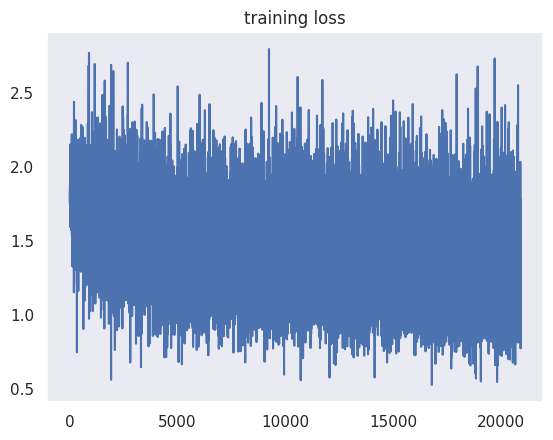

In [39]:
plt.plot(train_losses)
plt.title("training loss")

Text(0.5, 1.0, 'test accuracy')

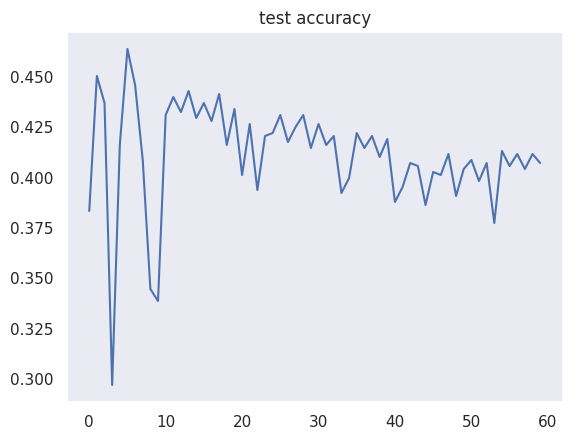

In [40]:
plt.plot(test_accuracy)
plt.title("test accuracy")

In [42]:
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

In [43]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 100/673 (0.1486)
F1: 0.1488095223903656
UAP: 0.23126746714115143
WAP: 0.1488095223903656
UAR: 0.2160966992378235
WAR: 0.1488095223903656
tensor([[11, 26, 43,  0, 96, 66],
        [ 1,  3, 10,  0, 27, 33],
        [ 0,  6,  8,  1, 73, 88],
        [ 0,  4,  0,  0,  6, 24],
        [ 0,  1,  1,  0, 22, 60],
        [ 0,  0,  0,  0,  6, 56]], device='cuda:0')
